Find best outer ring width so that the propagation constant matches at 1550nm

In [138]:
import numpy as np
from scipy.linalg import lstsq
import numbers
from Functions import *

width_inner = 8um

In [139]:
filename = '../data/Parameter Sweep data/' + 'Scanning_Lx_around2_6um_L_inner_8um_gap_3_5um.txt'

In [140]:
Beta_Inner_ring_width_8um = 6031.53863184           # L_inner = 8 um

In [141]:
def text_on_plot(residual,coefficients,Best_Lx):
    if isinstance(residual, numbers.Number):
        text = "RSS = " + f"{residuals:.6f}" + "\n"
    else:
        text = ""
    text = text + \
    "Curve_fitted: y= " + "{:.2f}".format(coefficients[2]) + r"$x^2$"
    if coefficients[1] > 0:
        text = text + "+"+"{:.2f}".format(coefficients[1]) + r"$x$"
    else:
        text = text + "-"+"{:.2f}".format(-coefficients[1]) + r"$x$"
    if coefficients[0] > 0:
        text = text + "+"+"{:.2f}".format(coefficients[0])
    else:
        text = text + "-"+"{:.2f}".format(-coefficients[0])
    if not Best_Lx[0] == 0:
        text = text + "\n"+ "Optimized Lx = " + "{:.0f}".format(Best_Lx[0]*1e3) +" nm"
    return text

In [142]:
gap_arr     = [2.5,3.0,3.5,4.0,4.5,5.0]
width_arr = [2856,2762,2673,2589,2511,2436]
#gap: 2.6 um, L_outer: 2837 nm

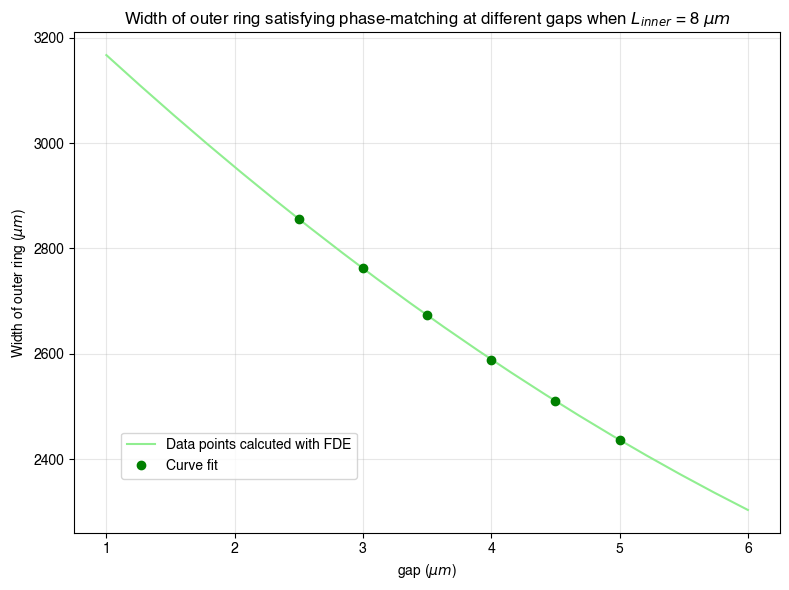

In [143]:
coefficients = np.polyfit(gap_arr, width_arr, 2)
polynomial = np.poly1d(coefficients)
r_fit = np.linspace(1, 6, 20)
width_fit = polynomial(gap_fit)

color_list      = ['lightgreen','green','deepskyblue','lightskyblue']*2

data_arr = (np.c_[gap_fit,width_fit],np.c_[gap_arr,width_arr])
param_dict   = {"Y_legends"     : ["Data points calcuted with FDE","Curve fit"],
                "X_label"       : r"gap ($\mu m$)",
                "Y_label"       : r"Width of outer ring ($\mu m$)",
                "title"         : r"Width of outer ring satisfying phase-matching at different gaps when $L_{inner}$ = 8 $\mu m$",
                "figsize"       : (8,6),
                "marker_list"   : ["","o"]*2,
                "linestyle_list": ["-",""]*2,
                "colors_list"   : color_list,
                # "xlim"          : (1.45,1.65),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : False,
                "bbox_legend"   :(0.4,0.2)}

Plot_curve(data_arr, **param_dict)

In [144]:
print(polynomial(2.75))

2808.3508928571423


Using Least square method to find best L_outer

In [145]:
def func(x,coeff):
    return coeff[2]*x**2 + coeff[1]*x + coeff[0]

In [146]:
data = np.loadtxt(filename,delimiter=',',dtype=float,skiprows=1)
Lx = data[:,0]

In [147]:
beta = data[:,1]

# 使用polyfit进行线性拟合，deg=1表示线性拟合
coefficients = np.polyfit(Lx, beta, 2)

# 使用poly1d生成多项式对象
polynomial = np.poly1d(coefficients)

# 打印拟合得到的系数
print("coefficients:", coefficients)

# 使用拟合得到的模型进行预测
width_fit = np.linspace(Lx[0], Lx[-1], 100000)
beta_fit = polynomial(width_fit)

coefficients: [ -11.83596517   98.11077974 5853.84379654]


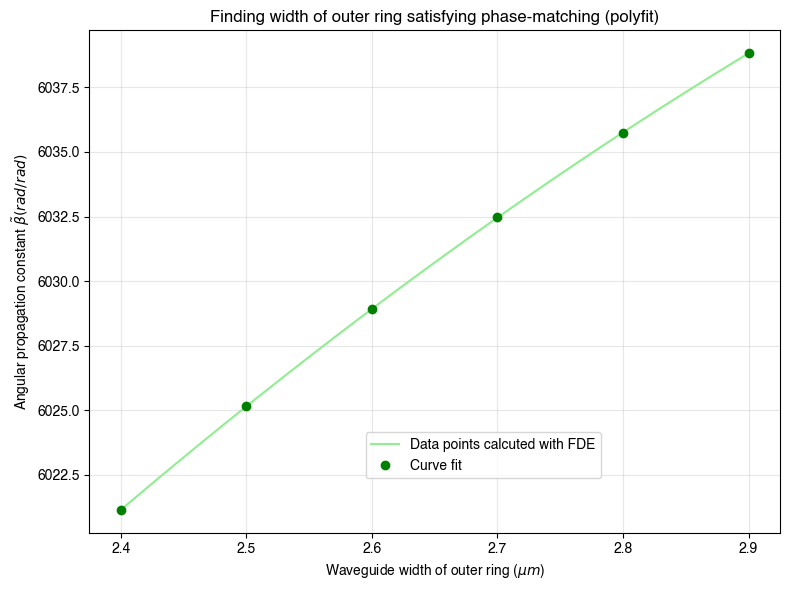

In [148]:
# 绘制原始数据和拟合曲线

color_list      = ['lightgreen','green','deepskyblue','lightskyblue']*2

data_arr = (np.c_[width_fit,beta_fit],np.c_[Lx,beta])
param_dict   = {"Y_legends"     : ["Data points calcuted with FDE","Curve fit"],
                "X_label"       : r"Waveguide width of outer ring ($\mu m$)",
                "Y_label"       : r"Angular propagation constant $\tilde{\beta}(rad/rad)$",
                "title"         : "Finding width of outer ring satisfying phase-matching (polyfit)",
                "figsize"       : (8,6),
                "marker_list"   : ["","o"]*2,
                "linestyle_list": ["-",""]*2,
                "colors_list"   : color_list,
                # "xlim"          : (1.45,1.65),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : False,
                "bbox_legend"   :(0.4,0.2)}

Plot_curve(data_arr, **param_dict)


In [149]:
# Least Squared
Lx_expanded = np.c_[np.ones((np.shape(Lx)[0],1)),Lx,np.square(Lx)]
coefficients, residuals, rank, s = lstsq(Lx_expanded, beta)
print("最小二乘解 x:", coefficients)
print("残差平方和:", residuals)
print("矩阵 A 的秩:", rank)
print("奇异值:", s)

最小二乘解 x: [5853.84379654   98.11077974  -11.83596517]
残差平方和: 0.001152836732549329
矩阵 A 的秩: 3
奇异值: [1.87443831e+01 4.83275627e-01 6.91157443e-03]


In [150]:
def func(x,coefficients):
    a,b,c = coefficients
    return c*x**2+b*x+a

In [151]:
def find_best_value(x_fit,y_fit,goal):
    y_fit = y_fit - goal
    res = np.array([])
    found = False
    idx = -1
    for i in range(len(y_fit)-1):
        if found:
            idx = i
            found = False
            continue
        if y_fit[i] * y_fit[i+1] <= 0:
            found = True
            if y_fit[i] * y_fit[i+1] < 0:
                res = np.append(res,(x_fit[i]+x_fit[i+1])/2)
            elif y_fit[i] == 0:
                res = np.append(res,x_fit[i])
            else:
                res = np.append(res,x_fit[i+1])
    return res,idx


In [152]:
Best_Lx,idx = find_best_value(width_fit, beta_fit,Beta_Inner_ring_width_8um)
beta_fit[idx]

np.float64(6031.538717997163)

In [153]:
Best_Lx

array([2.67334023])

[5853.84379654   98.11077974  -11.83596517]


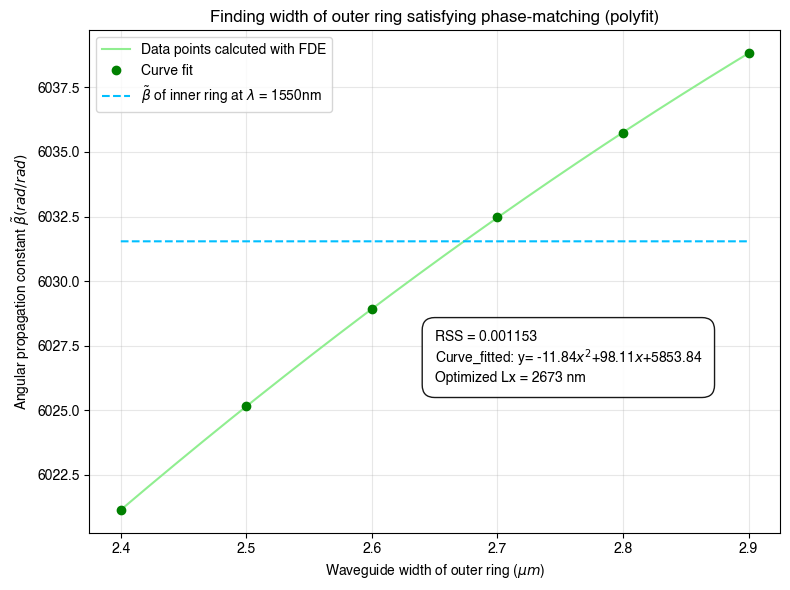

In [154]:
# Fit curve using Least Square method
r_fit = np.linspace(Lx[0], Lx[-1], 100000)
n_fit = func(r_fit,coefficients)

text = text_on_plot(residuals,coefficients,Best_Lx)


color_list      = ['lightgreen','green','deepskyblue','lightskyblue']*2

data_arr     = (np.c_[width_fit,beta_fit],np.c_[Lx,beta],
                np.c_[width_fit,np.ones(np.shape(r_fit))*Beta_Inner_ring_width_8um])
param_dict   = {"Y_legends"     : ["Data points calcuted with FDE", "Curve fit", r"$\tilde{\beta}$ of inner ring at $\lambda$ = 1550nm"],
                "X_label"       : r"Waveguide width of outer ring ($\mu m$)",
                "Y_label"       : r"Angular propagation constant $\tilde{\beta}(rad/rad)$",
                "title"         : "Finding width of outer ring satisfying phase-matching (polyfit)",
                "figsize"       : (8,6),
                "marker_list"   : ["","o",""]*2,
                "linestyle_list": ["-","","--"]*2,
                "colors_list"   : color_list,
                # "xlim"          : (1.45,1.65),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : False,
                "text"          : text,
                "loc_text"      : (0.5,0.3),
}

Plot_curve(data_arr, **param_dict)
print(coefficients)


L_inner = 2.8um

In [155]:
# Beta_Inner_ring_width_2_8um = 5982.502609467176       # L_inner = 2.8um
# Beta_Upper_ring_width_2_8um = 5983.180936564255       # L_inner = 2.8um

In [156]:
gap_arr = [3,4,5]
width_arr = [1988,1887,1793]

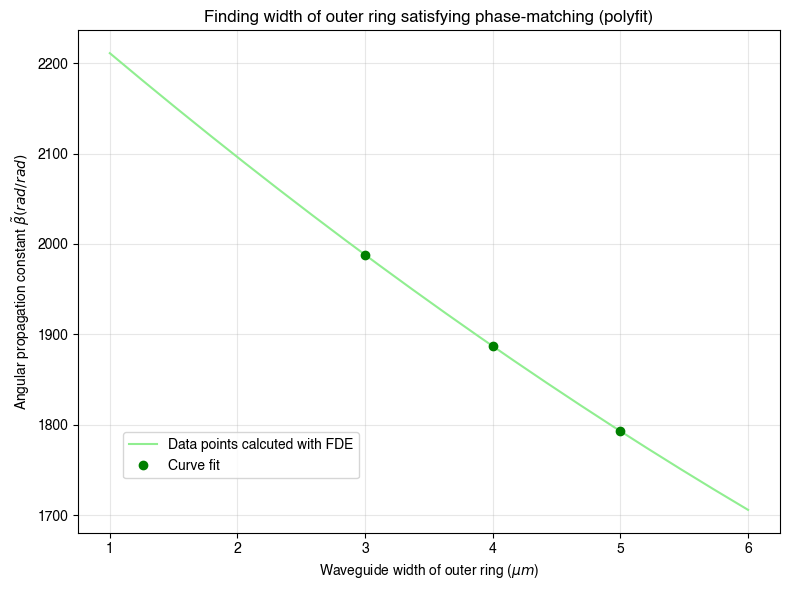

In [157]:
coefficients    = np.polyfit(gap_arr, width_arr, 2)
polynomial      = np.poly1d(coefficients)
gap_fit         = np.linspace(1, 6, 20)
width_fit       = polynomial(gap_fit)

color_list      = ['lightgreen','green','deepskyblue','lightskyblue']*2

data_arr        = (np.c_[gap_fit,width_fit],np.c_[gap_arr,width_arr])
param_dict   = {"Y_legends"     : ["Data points calcuted with FDE","Curve fit"],
                "X_label"       : r"Waveguide width of outer ring ($\mu m$)",
                "Y_label"       : r"Angular propagation constant $\tilde{\beta}(rad/rad)$",
                "title"         : "Finding width of outer ring satisfying phase-matching (polyfit)",
                "figsize"       : (8,6),
                "marker_list"   : ["","o"]*2,
                "linestyle_list": ["-",""]*2,
                "colors_list"   : color_list,
                # "xlim"          : (1.45,1.65),
                # "ylim"          : (-10000,9000),
                "AD_region_color"    : False,
                "bbox_legend"   :(0.4,0.2)}

Plot_curve(data_arr, **param_dict)


In [158]:
print(polynomial(2.75))

2014.3437499999998
